In [ ]:
!pip install -q minisom

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial.distance import cdist
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, Input, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from minisom import MiniSom

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Datasets

In [ ]:
train_img_path = '/content/drive/MyDrive/NN_DL/CASIA V1 Train - Normalized Images.npy'
test_img_path = '/content/drive/MyDrive/NN_DL/CASIA V1 Test - Normalized Images.npy'
train_feat_path = '/content/drive/MyDrive/NN_DL/CASIA V1 Train - Feature Extracted Images.npy'
test_feat_path = '/content/drive/MyDrive/NN_DL/CASIA V1 Test - Feature Extracted Images.npy'
train_labels_path = '/content/drive/MyDrive/NN_DL/CASIA V1 Train - Labels.npy'
test_labels_path = '/content/drive/MyDrive/NN_DL/CASIA V1 Test - Labels.npy'

In [ ]:
train_img = np.load(train_img_path)
test_img = np.load(test_img_path)
train_feat = np.load(train_feat_path)
test_feat = np.load(test_feat_path)
train_labels = np.load(train_labels_path)
test_labels = np.load(test_labels_path)

In [ ]:
# Extract unique identifiers from labels
def extract_id(labels):
    return np.array([int(label.split('_')[0]) for label in labels])

In [ ]:
train_labels = extract_id(train_labels)
test_labels = extract_id(test_labels)

In [ ]:
train_labels = train_labels - 1
test_labels = test_labels - 1

In [ ]:
num_classes = 108
train_labels_cat = to_categorical(train_labels, num_classes)
test_labels_cat = to_categorical(test_labels, num_classes)

In [ ]:
train_img = train_img.reshape((-1, 20, 240, 1))
test_img = test_img.reshape((-1, 20, 240, 1))
train_feat = train_feat.reshape((-1, 20, 480, 1))
test_feat = test_feat.reshape((-1, 20, 480, 1))

In [ ]:
# Flatten image data
train_img = train_img.reshape(648, -1)
test_img = test_img.reshape(108, -1)
train_feat = train_feat.reshape(648, -1)
test_feat = test_feat.reshape(108, -1)

In [ ]:
# Normalize images - mean 0 & std 1
scaler = StandardScaler()
train_img = scaler.fit_transform(train_img)
test_img = scaler.transform(test_img)
train_feat = scaler.fit_transform(train_feat)
test_feat = scaler.transform(test_feat)

# RBFNN

## Dataset Normalized Images

In [ ]:
num_centers = 108 # RBF centers
# K-Means to find centers
kmeans = KMeans(n_clusters=num_centers, random_state=42)
kmeans.fit(train_img)
centers = kmeans.cluster_centers_

In [ ]:
# Compute RBF kernel
def rbf_kernel(X, centers, sigma=1.0):
    distances = cdist(X, centers, metric='euclidean')
    return np.exp(- (distances ** 2) / (2 * sigma ** 2))

In [ ]:
# Compute RBF feature matrices
sigma = np.mean(cdist(centers, centers, 'euclidean'))
train_rbf_features = rbf_kernel(train_img, centers, sigma)
test_rbf_features = rbf_kernel(test_img, centers, sigma)

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
train_labels_onehot = encoder.fit_transform(train_labels.reshape(-1, 1))
test_labels_onehot = encoder.transform(test_labels.reshape(-1, 1))

In [ ]:
clf = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42)
clf.fit(train_rbf_features, train_labels)

RandomForestClassifier(n_estimators=300, random_state=42)

In [ ]:
predictions = clf.predict(test_rbf_features)
accuracy = accuracy_score(test_labels, predictions)
print(f"Test Accuracy on Normalized Images dataset: {accuracy * 100:.2f} %")

Test Accuracy on Normalized Images dataset: 65.74 %


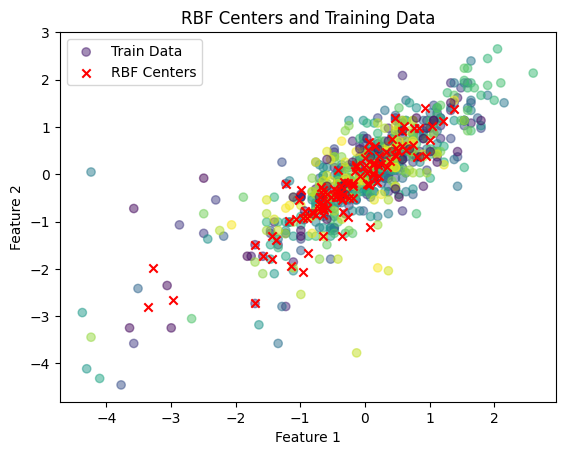

In [ ]:
plt.scatter(train_img[:, 0], train_img[:, 1], c=train_labels, cmap='viridis', alpha=0.5, label='Train Data')
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', label='RBF Centers')
plt.legend()
plt.title("RBF Centers and Training Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

## Dataset Feature Extracted Images

In [ ]:
num_centers = 108 # RBF centers
# K-Means to find centers
kmeans = KMeans(n_clusters=num_centers, random_state=42)
kmeans.fit(train_feat)
centers = kmeans.cluster_centers_

In [ ]:
# Compute RBF feature matrices
sigma = np.mean(cdist(centers, centers, 'euclidean'))
train_rbf_features = rbf_kernel(train_feat, centers, sigma)
test_rbf_features = rbf_kernel(test_feat, centers, sigma)

In [ ]:
clf = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42)
clf.fit(train_rbf_features, train_labels)

RandomForestClassifier(n_estimators=300, random_state=42)

In [ ]:
predictions = clf.predict(test_rbf_features)
accuracy = accuracy_score(test_labels, predictions)
print(f"Test Accuracy on Feature Extracted Images dataset: {accuracy * 100:.2f} %")

Test Accuracy on Feature Extracted Images dataset: 80.56 %


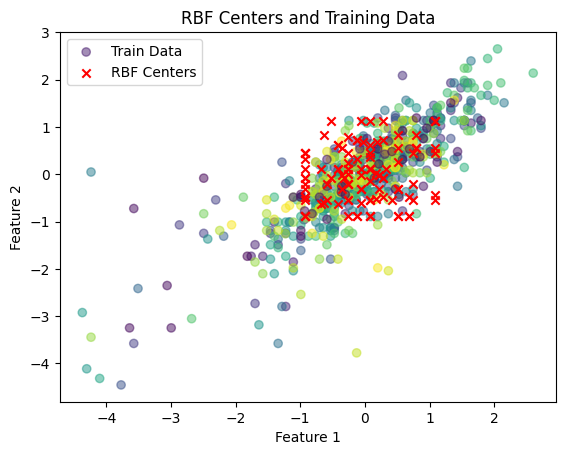

In [ ]:
plt.scatter(train_img[:, 0], train_img[:, 1], c=train_labels, cmap='viridis', alpha=0.5, label='Train Data')
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', label='RBF Centers')
plt.legend()
plt.title("RBF Centers and Training Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# CNN

## Dataset Normalized Images

In [ ]:
def residual_block(x, filters, stride=1, second_stride=1, repeat=1):
    for i in range(repeat):
        shortcut = x

        x = Conv2D(filters, kernel_size=3, strides=stride if i == 0 else second_stride, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)

        if (stride != 1 and i == 0) or shortcut.shape[-1] != filters:
            shortcut = Conv2D(filters, kernel_size=1, strides=stride, use_bias=False)(shortcut)
            shortcut = BatchNormalization()(shortcut)

        x = Add()([x, shortcut])
        x = ReLU()(x)

    return x

In [ ]:
def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = residual_block(x, 64, stride=1, second_stride=1, repeat=2)
    x = residual_block(x, 128, stride=2, second_stride=1, repeat=2)
    x = residual_block(x, 256, stride=2, second_stride=1, repeat=2)
    x = residual_block(x, 512, stride=2, second_stride=1, repeat=2)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, x)
    return model

In [ ]:
input_shape = (20, 240, 1)
num_classes = 108
model = build_resnet(input_shape, num_classes)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_img, train_labels, batch_size=16, epochs=30, verbose=1)

Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 58s 997ms/step - accuracy: 0.0256 - loss: 5.3461
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 916ms/step - accuracy: 0.1660 - loss: 3.5127
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 916ms/step - accuracy: 0.2521 - loss: 2.8751
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 909ms/step - accuracy: 0.4117 - loss: 2.1253
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 946ms/step - accuracy: 0.5551 - loss: 1.6084
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 936ms/step - accuracy: 0.7367 - loss: 1.0667
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 911ms/step - accuracy: 0.8526 - loss: 0.6832
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 43s 960ms/step - accuracy: 0.8611 - loss: 0.5908
Epoch 9/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 901ms/step - accuracy: 0.9417 - loss: 0.3128
Epoch 10/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 906ms/step - accuracy: 0.9775 - loss: 0.1502
Epoch 11/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 926ms/step - accuracy: 0.9845 - loss: 0.1153
Epoch 12/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 41

In [ ]:
test_loss, test_acc = model.evaluate(test_img, test_labels, verbose=1)
print(f"Test Accuracy on Normalized Images dataset: {test_acc * 100:.2f} %")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.8975 - loss: 0.6895
Test Accuracy on Normalized Images dataset: 92.59 %


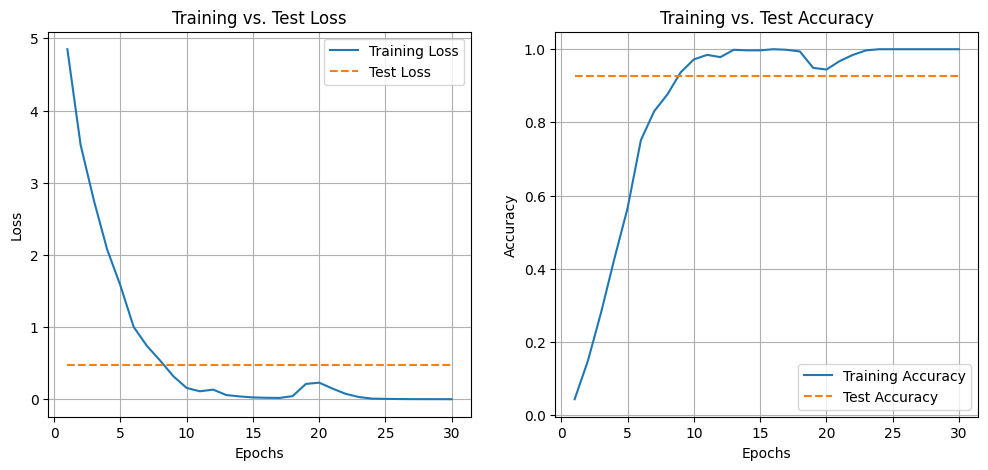

In [ ]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
test_loss = [test_loss] * len(train_loss)
test_acc = [test_acc] * len(train_acc)

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(train_loss) + 1), test_loss, label='Test Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Test Loss')
plt.legend()
plt.grid()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(train_acc) + 1), test_acc, label='Test Accuracy', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Test Accuracy')
plt.legend()
plt.grid()

plt.show()

## Dataset Feature Extracted Images

In [ ]:
input_shape = (20, 480, 1)
num_classes = 108
model = build_resnet(input_shape, num_classes)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_feat, train_labels, batch_size=16, epochs=30, verbose=1)

Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.0536 - loss: 5.1923
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6521 - loss: 2.1028
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9521 - loss: 0.5099
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 1.0000 - loss: 0.0726
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 1.0000 - loss: 0.0134
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 1.0000 - loss: 0.0064
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 1.0000 - loss: 0.0041
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 1.0000 - loss: 0.0034
Epoch 9/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 1.0000 - loss: 0.0028
Epoch 10/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 1.0000 - loss: 0.0024
Epoch 11/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 1.0000 - loss: 0.0020
Epoch 12/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 1.0000 - lo

In [ ]:
test_loss, test_acc = model.evaluate(test_feat, test_labels, verbose=1)
print(f"Test Accuracy on Feature Extracted Images dataset: {test_acc * 100:.2f} %")

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step - accuracy: 0.8723 - loss: 0.8475
Test Accuracy on Feature Extracted Images dataset: 90.74 %


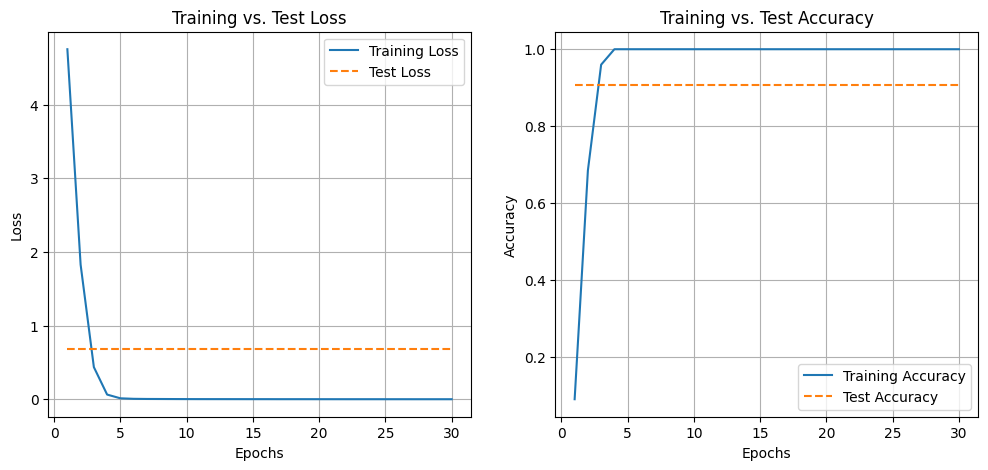

In [ ]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
test_loss = [test_loss] * len(train_loss)
test_acc = [test_acc] * len(train_acc)

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(train_loss) + 1), test_loss, label='Test Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Test Loss')
plt.legend()
plt.grid()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(train_acc) + 1), test_acc, label='Test Accuracy', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Test Accuracy')
plt.legend()
plt.grid()

plt.show()

# VGG16

## Dataset Normalized Images

In [ ]:
train_img_resized = tf.image.resize(train_img, (32, 240))
test_img_resized = tf.image.resize(test_img, (32, 240))

In [ ]:
train_img_rgb = tf.image.grayscale_to_rgb(train_img_resized)
test_img_rgb = tf.image.grayscale_to_rgb(test_img_resized)

In [ ]:
num_classes = 108
input_shape = (32, 240, 3)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=x)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_img_rgb, train_labels_cat, batch_size=16, epochs=30, verbose=1)

Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.0025 - loss: 4.8423
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.0158 - loss: 4.6285
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.0593 - loss: 4.3841
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.1026 - loss: 4.1053
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.1655 - loss: 3.6044
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.2478 - loss: 3.1066
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.3954 - loss: 2.6875
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.4012 - loss: 2.3609
Epoch 9/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.4921 - loss: 1.9837
Epoch 10/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.5951 - loss: 1.6816
Epoch 11/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.6636 - loss: 1.4642
Epoch 12/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.7057 - lo

In [ ]:
test_loss, test_acc = model.evaluate(test_img_rgb, test_labels_cat)
print(f"Test Accuracy on Normalized Images dataset: {test_acc * 100:.2f} %")

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6696 - loss: 2.2857
Test Accuracy on Normalized Images dataset: 71.30 %


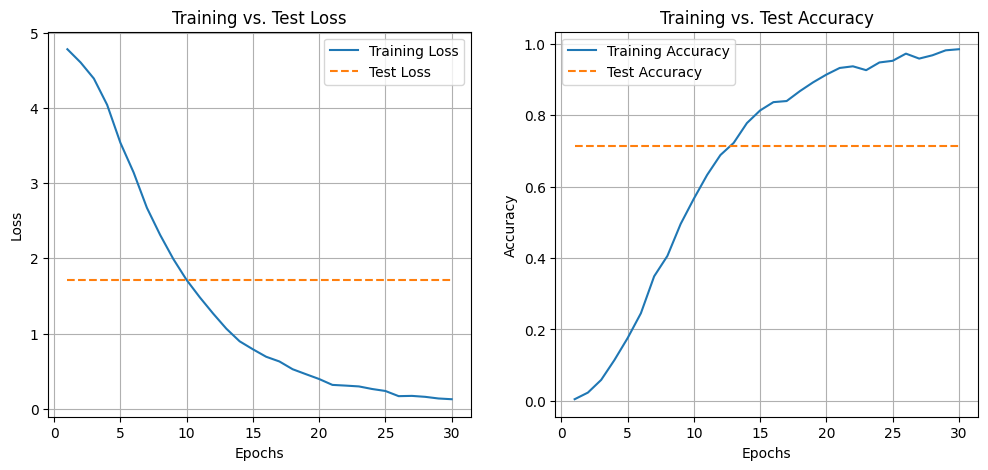

In [ ]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
test_loss = [test_loss] * len(train_loss)
test_acc = [test_acc] * len(train_acc)

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(train_loss) + 1), test_loss, label='Test Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Test Loss')
plt.legend()
plt.grid()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(train_acc) + 1), test_acc, label='Test Accuracy', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Test Accuracy')
plt.legend()
plt.grid()

plt.show()

## Dataset Feature Extracted Images

In [ ]:
train_feat_resized = tf.image.resize(train_feat, (32, 480))
test_feat_resized = tf.image.resize(test_feat, (32, 480))

In [ ]:
train_feat_rgb = tf.image.grayscale_to_rgb(train_feat_resized)
test_feat_rgb = tf.image.grayscale_to_rgb(test_feat_resized)

In [ ]:
num_classes = 108
input_shape = (32, 480, 3)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=x)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_feat_rgb, train_labels_cat, batch_size=16, epochs=30, verbose=1)

Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.0113 - loss: 4.9819
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.0172 - loss: 4.6839
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.0333 - loss: 4.6121
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.0637 - loss: 4.4151
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.0869 - loss: 4.1007
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.1207 - loss: 3.8426
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.2045 - loss: 3.4435
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.2733 - loss: 3.1174
Epoch 9/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.3327 - loss: 2.7847
Epoch 10/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.3739 - loss: 2.5433
Epoch 11/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.4322 - loss: 2.2439
Epoch 12/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_feat_rgb, test_labels_cat)
print(f"Test Accuracy on Feature Extracted Images dataset: {test_acc * 100:.2f} %")

4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 8s/step - accuracy: 0.4598 - loss: 2.8269
Test Accuracy on Feature Extracted Images dataset: 49.07 %


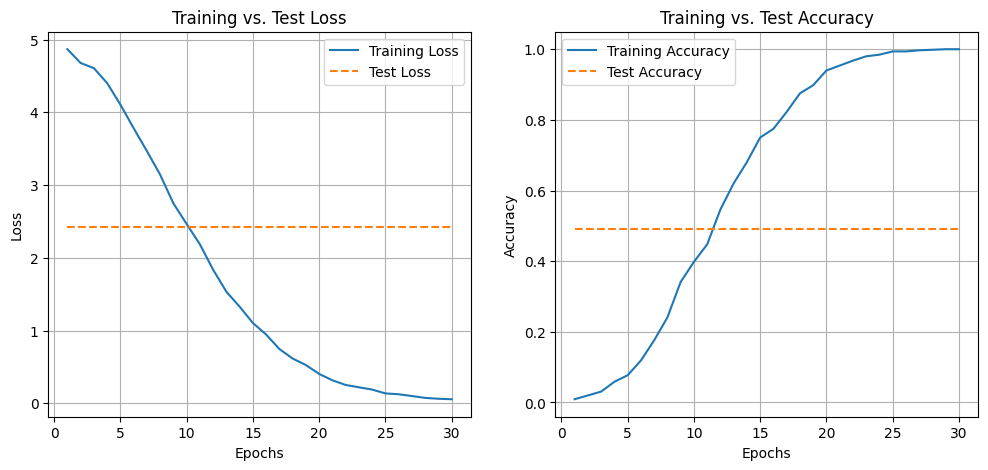

In [ ]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
test_loss = [test_loss] * len(train_loss)
test_acc = [test_acc] * len(train_acc)

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(train_loss) + 1), test_loss, label='Test Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Test Loss')
plt.legend()
plt.grid()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(train_acc) + 1), test_acc, label='Test Accuracy', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Test Accuracy')
plt.legend()
plt.grid()

plt.show()

# SOM + MLP

## Dataset Normalized Images

In [ ]:
num_classes = 108

train_labels = np.array(train_labels, dtype=int)
test_labels = np.array(test_labels, dtype=int)

train_labels = to_categorical(train_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [ ]:
som_size = (12, 12)
som = MiniSom(som_size[0], som_size[1], train_img.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(train_img)

In [ ]:
print("Training SOM...")
som.train_random(train_img, num_iteration=1000)

Training SOM...


In [ ]:
def get_som_features(som, X):
    return np.array([som.winner(x) for x in X])

In [ ]:
train_features = get_som_features(som, train_img)
test_features = get_som_features(som, test_img)

In [ ]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(train_features.shape[1],)),
    Dense(128, activation='relu'),
    Dense(108, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_features, train_labels, batch_size=16, epochs=200)

Epoch 1/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0101 - loss: 4.7302
Epoch 2/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0304 - loss: 4.5299
Epoch 3/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0355 - loss: 4.3802
Epoch 4/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0344 - loss: 4.2173
Epoch 5/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0614 - loss: 4.0621
Epoch 6/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0382 - loss: 4.0026
Epoch 7/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0638 - loss: 3.8981
Epoch 8/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0805 - loss: 3.7753
Epoch 9/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0665 - loss: 3.6615
Epoch 10/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0924 - loss: 3.5817
Epoch 11/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1026 - loss: 3.4396
Epoch 12/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_features, test_labels)
print(f"Test Accuracy on Normalized Images dataset: {test_acc * 100:.2f} %")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4983 - loss: 7.2303  
Test Accuracy on Normalized Images dataset: 47.22 %


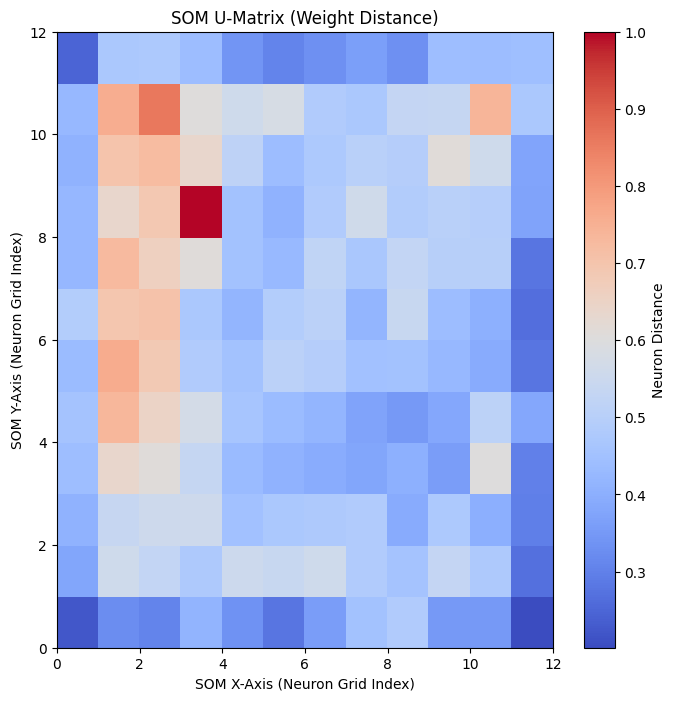

In [ ]:
# Plot U-Matrix (Unified Distance Matrix)
plt.figure(figsize=(8, 8))
plt.pcolor(som.distance_map().T, cmap='coolwarm')
plt.colorbar(label="Neuron Distance")
plt.xlabel("SOM X-Axis (Neuron Grid Index)")
plt.ylabel("SOM Y-Axis (Neuron Grid Index)")
plt.title("SOM U-Matrix (Weight Distance)")
plt.show()

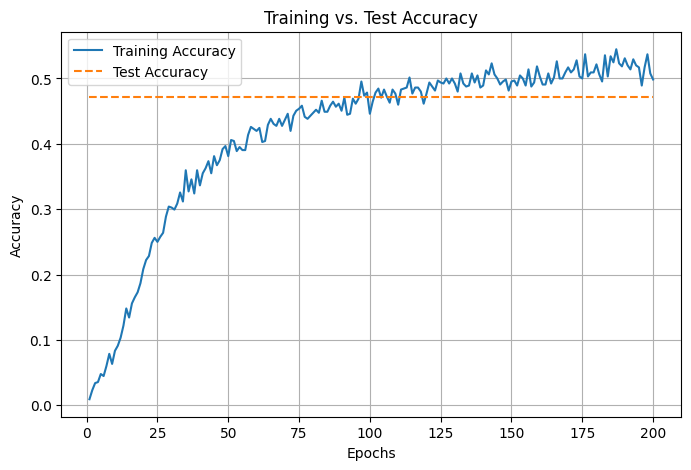

In [ ]:
train_acc = history.history['accuracy']
test_acc = [test_acc] * len(train_acc)

plt.figure(figsize=(8, 5))

# Accuracy Plot
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(train_acc) + 1), test_acc, label='Test Accuracy', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Test Accuracy')
plt.legend()
plt.grid()
plt.show()

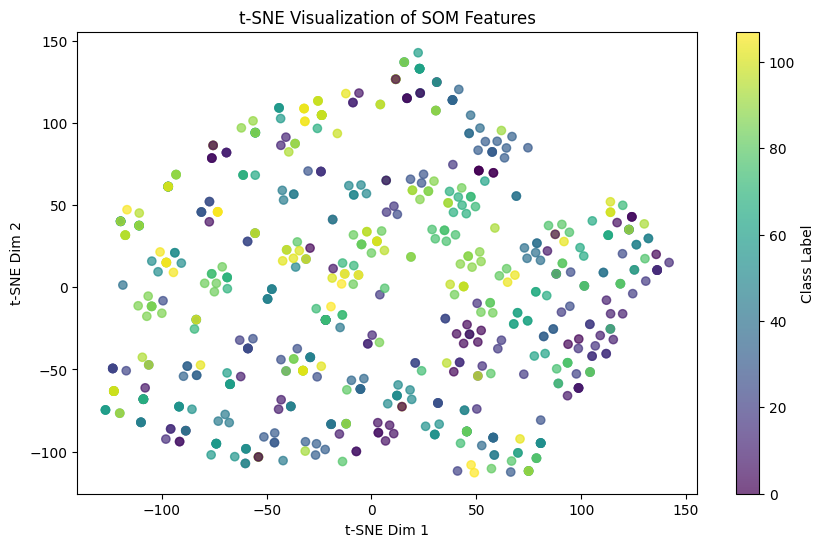

In [ ]:
# Reduce SOM features to 2D for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
train_tsne = tsne.fit_transform(train_features)

plt.figure(figsize=(10, 6))
plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=np.argmax(train_labels, axis=1), cmap='viridis', alpha=0.7)
plt.colorbar(label='Class Label')
plt.title('t-SNE Visualization of SOM Features')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.show()

## Dataset Feature Extracted Images

In [ ]:
som_size = (12, 12)
som = MiniSom(som_size[0], som_size[1], train_feat.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(train_feat)

In [ ]:
print("Training SOM...")
som.train_random(train_feat, num_iteration=1000)

Training SOM...


In [ ]:
train_features = get_som_features(som, train_feat)
test_features = get_som_features(som, test_feat)

In [ ]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(train_features.shape[1],)),
    Dense(128, activation='relu'),
    Dense(108, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_features, train_labels, batch_size=16, epochs=200)

Epoch 1/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0121 - loss: 4.7711
Epoch 2/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0166 - loss: 4.5190
Epoch 3/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0385 - loss: 4.2585
Epoch 4/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0382 - loss: 4.1213
Epoch 5/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0432 - loss: 3.9993
Epoch 6/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0716 - loss: 3.8718
Epoch 7/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0643 - loss: 3.7915
Epoch 8/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1001 - loss: 3.6700
Epoch 9/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1045 - loss: 3.6249
Epoch 10/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1144 - loss: 3.5704
Epoch 11/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0893 - loss: 3.5420
Epoch 12/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_features, test_labels)
print(f"Test Accuracy on Feature Extracted Images dataset: {test_acc * 100:.2f} %")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7123 - loss: 4.9327
Test Accuracy on Feature Extracted Images dataset: 71.30 %


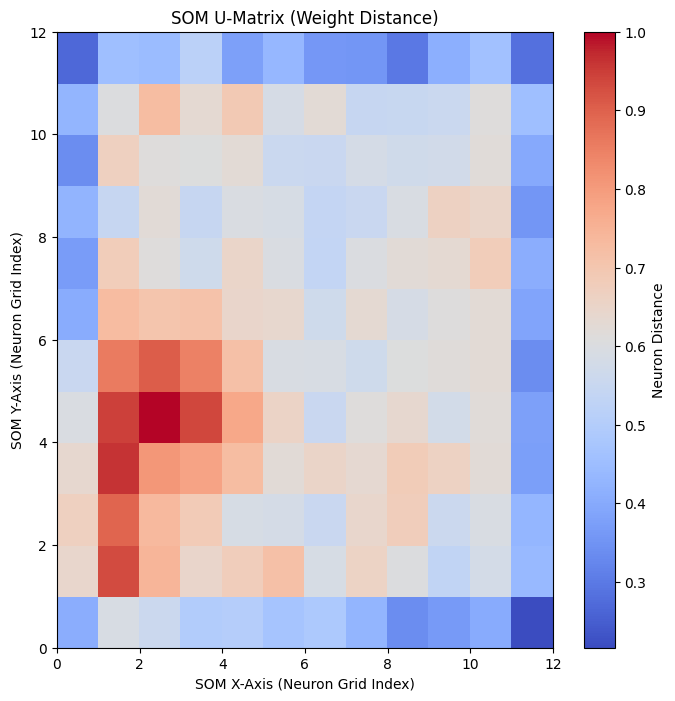

In [ ]:
# Plot U-Matrix (Unified Distance Matrix)
plt.figure(figsize=(8, 8))
plt.pcolor(som.distance_map().T, cmap='coolwarm')
plt.colorbar(label="Neuron Distance")
plt.xlabel("SOM X-Axis (Neuron Grid Index)")
plt.ylabel("SOM Y-Axis (Neuron Grid Index)")
plt.title("SOM U-Matrix (Weight Distance)")
plt.show()

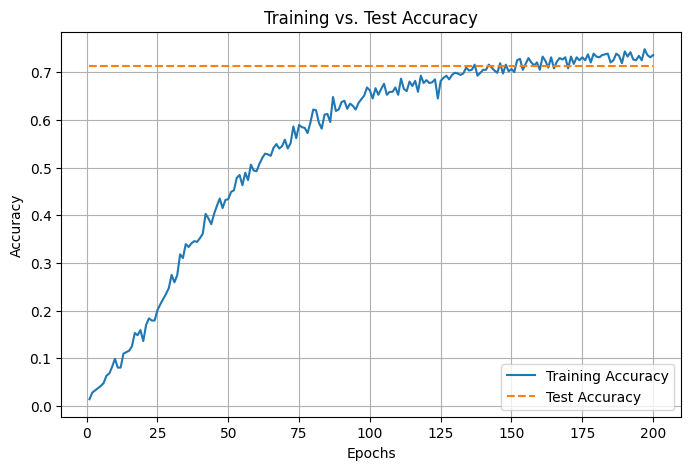

In [ ]:
train_acc = history.history['accuracy']
test_acc = [test_acc] * len(train_acc)

plt.figure(figsize=(8, 5))

# Accuracy Plot
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(train_acc) + 1), test_acc, label='Test Accuracy', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Test Accuracy')
plt.legend()
plt.grid()
plt.show()

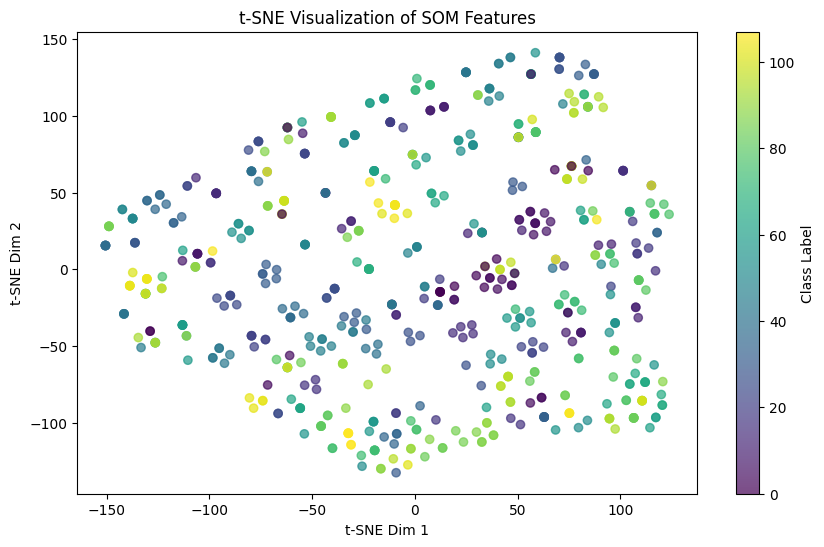

In [ ]:
# Reduce SOM features to 2D for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
train_tsne = tsne.fit_transform(train_features)

plt.figure(figsize=(10, 6))
plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=np.argmax(train_labels, axis=1), cmap='viridis', alpha=0.7)
plt.colorbar(label='Class Label')
plt.title('t-SNE Visualization of SOM Features')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.show()